In [21]:
from datasets import load_dataset
from transformers import AutoTokenizer
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
dataset = load_dataset('imdb')

In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: ', {device})

Using Device:  {device(type='cuda')}


In [8]:
image_path = 'rose.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



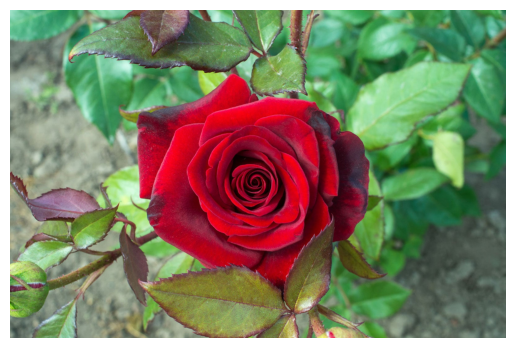

In [9]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [10]:
def preprocess_image(image):
    resized_image = cv2.resize(image, (64, 64))
    normalize_image = resized_image.astype('float32') /255.0
    return normalize_image

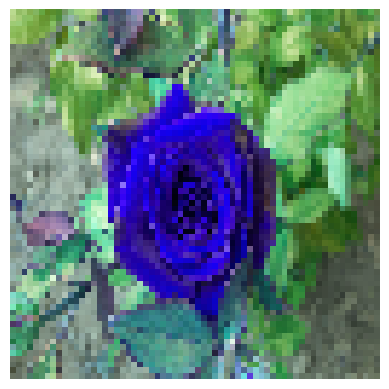

In [11]:
preprocess_image = preprocess_image(image)
plt.imshow(preprocess_image)
plt.axis('off')
plt.show()

In [22]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_val=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_val = is_val
        
        self.image_paths = []
        self.labels = []
        self.bounding_boxes = []
        self.label_to_index = {}  # Add this to map labels to indices
        self.current_index = 0
        
        if is_val:
            self._load_val_images()
        else:
            self._load_train_images()

    def _load_train_images(self):
        for label_folder in os.listdir(self.root_dir):
            label_folder_path = os.path.join(self.root_dir, label_folder)
            if os.path.isdir(label_folder_path):
                annotation_file = os.path.join(label_folder_path, f'{label_folder}_boxes.txt')
                if os.path.exists(annotation_file):
                    if label_folder not in self.label_to_index:
                        self.label_to_index[label_folder] = self.current_index
                        self.current_index += 1

                    with open(annotation_file, 'r') as file:
                        for line in file:
                            parts = line.strip().split()
                            img_name = parts[0]
                            if len(parts) >= 5:
                                x_min, y_min, width, height = map(int, parts[1:5])
                                img_path = os.path.join(label_folder_path, 'images', img_name)
                                self.image_paths.append(img_path)
                                self.labels.append(self.label_to_index[label_folder])
                                self.bounding_boxes.append([x_min, y_min, width, height])

    def _load_val_images(self):
        val_image_dir = os.path.join(self.root_dir, 'images')
        for img_name in os.listdir(val_image_dir):
            img_path = os.path.join(val_image_dir, img_name)
            self.image_paths.append(img_path)
            self.labels.append(self.label_to_index.get(img_name.split('_')[0], -1))  # Handle validation set if necessary
            self.bounding_boxes.append(None)  # No bounding boxes for validation set

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        image = Image.fromarray(image)  # Convert numpy array to PIL Image
        label = torch.tensor(self.labels[idx])  # Ensure label is a tensor
        bbox = self.bounding_boxes[idx]

        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and tensor label
    

In [23]:
class ToTensor(object):
    def __call__(self, image):
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image) 
        image = transforms.ToTensor()(image) 
        return image

# Define your image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    ToTensor()  
])

In [24]:
train_dataset = TinyImageNetDataset(root_dir='data/tiny-imagenet-2001/train', transform=transform)
val_dataset = TinyImageNetDataset(root_dir='data/tiny-imagenet-2001/val', transform=transform, is_val=True)


In [25]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [26]:
print(f'The val is   ', len(val_dataset))
print(f'The train is ', len(train_dataset))

The val is    10000
The train is  100000


In [27]:
class ImageCNN(nn.Module):
    def __init__(self):
        super(ImageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128) 
        self.fc2 = nn.Linear(128, 200) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
model = ImageCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [29]:
len(train_loader)

3125

In [ ]:
for epoch in range(1):  # Number of epochs
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Validation step
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)


            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f'Validation Accuracy: {100 * correct / total}%')